## Control Scraping and Metadata Analysis
Purpose of this notebook is to scrape the control users and perform some rudimentary analysis on the metadata extracted from these users.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from tqdm import tqdm

from datetime import datetime

import praw
from psaw import PushshiftAPI
from collections import Counter, OrderedDict

In [2]:
api = PushshiftAPI()

client_id = ""
secret = ""
user_agent = "Mental Health Scraper 2"

reddit = praw.Reddit(client_id=client_id, client_secret=secret, user_agent=user_agent)

Version 7.1.0 of praw is outdated. Version 7.2.0 was released Wednesday February 24, 2021.


In [15]:
# helpers

def get_comment_meta(username):
    comment_subs = []
    comment_meta = []
    try:
        for comment in reddit.redditor(username).comments.new(limit = None):
            comment_subs.append(str(comment.subreddit))
            comment_meta.append([user, 0, str(comment.subreddit), ut_to_dt(comment.created_utc), comment.body, comment.ups, comment.downs, len(comment.replies)])
            
        comment_dict = Counter(comment_subs)

        return comment_meta, comment_dict
    
    except:
        return [],Counter([])
    
def get_post_meta(username):
    post_subs = []
    post_meta = []
    try:
        for submission in reddit.redditor(username).submissions.new(limit = None):
            post_subs.append(str(submission.subreddit))
            post_meta.append([user, 1, str(submission.subreddit), ut_to_dt(submission.created_utc), submission.title + ' ' + submission.selftext, submission.ups, submission.downs, submission.num_comments])
            
        post_dict = Counter(post_subs)
        
        return post_meta, post_dict
    
    except:
        return [],Counter([])
    

def ut_to_dt(created):
    '''
    To convert unix time to datetime format
    '''
    ts = int(created)
    return datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

In [90]:
depression_list = ['depression','depression_help','antidepressants','depressed', 'AnxietyDepression', 'AdultDepression']

anxiety_list = ['Anxiety','AnxietyDepression','socialanxiety','Anxietyhelp','adhd_anxiety','PanicAttack']

bipolar_list = ['bipolar','BipolarReddit']

bpd_list = ['BPD']

ptsd_list = ['CPTSD','ptsd']

ocd_list = ['OCD']

addiction_list = ['addiction','alcoholism','alcohol','cripplingalcoholism','alcoholicsanonymous',\
                  'opiates','heroin','cocaine','trees','Drugs','askdrugs','leaves'] # alcohol, opioids, general drug usage

schizo_list = ['schizophrenia']

eating_disorder_list = ['BingeEatingDisorder','EatingDisorders','fuckeatingdisorders','eating_disorders','bulimia']

self_harm_list = ['selfharm','SelfHarmScars']

lonely_list = ['lonely','ForeverAlone']

# external causes

sexual_list = ['rape','rapecounseling','sexualassault']

relationship_list = ['relationship_advice','relationships','abusiverelationships','survivinginfidelity',\
                     'cheating_stories','NarcissisticAbuse','abusiveparents','survivorsofabuse',\
                     'raisedbynarcissists','insaneparents','lossofalovedone','LostALovedOne','BreakUps','heartbreak']

In [91]:
MH_subs = depression_list + anxiety_list \
        + bpd_list + bipolar_list + ptsd_list \
        + ocd_list + addiction_list + schizo_list \
        + eating_disorder_list + self_harm_list \
        + lonely_list + sexual_list + relationship_list

In [9]:
control_dist = pd.read_csv('control_dist.csv') # distribution of MH subreddits in the target dataset

In [12]:
start_epoch=int(datetime(2017, 1, 1).timestamp())

res = []
for index, row in tqdm(control_dist.iterrows()):
    sub = row['subreddit']
    count = row['username']*2
    
    res += list(api.search_submissions(after= start_epoch, \
                                      limit = count,\
                                      filter = ["author","subreddit","title","selftext","created","num_comments","score","upvote_ratio"], \
                                      subreddit = sub))

0it [00:00, ?it/s]C:\ProgramData\Anaconda3\envs\myds\lib\site-packages\psaw\PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
C:\ProgramData\Anaconda3\envs\myds\lib\site-packages\psaw\PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")
C:\ProgramData\Anaconda3\envs\myds\lib\site-packages\psaw\PushshiftAPI.py:192: UserWarning: Got non 200 code 502
  warnings.warn("Got non 200 code %s" % response.status_code)
56it [09:02,  9.69s/it]


In [14]:
posts = []
for post in res:
    try:
        posts.append([post.author, post.subreddit, post.title, post.selftext, ut_to_dt(post.created_utc), post.num_comments, post.score])
    except:
        posts.append([post.author, post.subreddit, post.title, '', ut_to_dt(post.created_utc), post.num_comments, post.score])
posts = pd.DataFrame(posts,columns=["author","subreddit","title", "text", "created","num_comments","score"])

posts.head(n=3)

,author,subreddit,title,text,created,num_comments,score
0,X0-PPP,depression,Depression,I’m trade I am not smart. I’m not doing my job...,2021-04-02 14:30:40,0,1
1,1600rage,depression,Depressed and lonely,I've been alone for a couple months now. I see...,2021-04-02 14:28:33,0,1
2,Randomgirl2408,depression,A question for people who are diagnosed with d...,How is the diagnosis written in the report you...,2021-04-02 14:24:47,0,1


In [15]:
posts.to_csv('control_18v2.csv', index = False)

In [3]:
posts = pd.read_csv('control_18v2.csv')

In [4]:
posts.subreddit.value_counts()

depression              10236
relationship_advice      4868
relationships            2846
selfharm                 2374
Anxiety                  2284
raisedbynarcissists      1674
trees                    1640
Drugs                    1546
lonely                   1492
insaneparents            1224
BPD                      1028
BreakUps                  888
depression_help           884
ForeverAlone              820
socialanxiety             818
bipolar                   818
OCD                       626
SelfHarmScars             542
depressed                 538
CPTSD                     520
ptsd                      452
opiates                   348
schizophrenia             342
leaves                    318
BipolarReddit             226
heartbreak                220
addiction                 220
antidepressants           212
Anxietyhelp               212
rape                      212
AnxietyDepression         210
NarcissisticAbuse         194
cocaine                   192
alcoholism

In [7]:
rm_list = []

for sub in posts.subreddit.unique():
    for moderator in reddit.subreddit(sub).moderator():
        rm_list.append(str(moderator))
    
rm_list.append('[deleted]') # no use from deleted accounts

In [12]:
print("Number of moderators across all subreddits: ")
print(len(rm_list))

all_users = posts.author.unique().tolist()

print("Number of unique users found: ")
print(len(all_users))
#removing mods
all_users = [x for x in all_users if x not in rm_list]

print("Number of unique users remaining: ")
print(len(all_users))

Number of moderators across all subreddits: 
438
Number of unique users found: 
31682
Number of unique users remaining: 
31660


In [16]:
metadata_total_control = []
missed = []

i = 0

for i in tqdm(range(len(all_users))):
    user = all_users[i]
    comment_meta, comment_dict = get_comment_meta(user)
    post_meta, post_dict = get_post_meta(user)
    
    if ('SuicideWatch' not in post_dict.keys()):
        combined_meta = comment_meta + post_meta
        if len(combined_meta) != 0:
            metadata_total_control += combined_meta
            i+= 1
            
    if i % 2000 == 0:
        with open('metadata18v2/metcontrol'+str(i)+'.pkl', 'wb') as f:
            pickle.dump(metadata_total_control, f)

100%|█████████████████████████████████████████████████████████████████████████| 31660/31660 [15:56:02<00:00,  1.81s/it]


In [84]:
with open('metadata18v2/metcontrolfinal.pkl', 'wb') as f:
    pickle.dump(metadata_total_control, f)

In [24]:
metadata = pd.DataFrame(metadata_total_control, columns = ["username","type","subreddit","date","text","ups","downs","num_response"])
metadata['date'] = pd.to_datetime(metadata['date'], infer_datetime_format=True)
print(str(len(metadata.username.unique())) + " unique users found!")
display(metadata.head(), metadata.shape)

28223 unique users found!


,username,type,subreddit,date,text,ups,downs,num_response
0,X0-PPP,1,depression,2021-04-02 14:30:40,Depression I’m trade I am not smart. I’m not d...,3,0,1
1,X0-PPP,1,relationship_advice,2020-07-02 06:26:50,Boyfriend talks about his past relationships t...,2,0,4
2,1600rage,0,doomer,2021-02-04 09:30:00,I'm not a doctor but there are many reasons fo...,1,0,0
3,1600rage,0,playboicarti,2020-12-27 21:35:57,Probably was on so many drugs that he isn't re...,3,0,0
4,1600rage,0,magick,2020-12-22 07:58:06,Blessed be,3,0,0


(6572225, 8)

### Account Age

Date of last post - Date of first post = Age of account

In [49]:
account_dates = metadata.groupby('username').date.agg(first_act=np.min, last_act = np.max).reset_index()
account_dates['account_age'] = \
        (account_dates['last_act']-account_dates['first_act']).astype('timedelta64[D]')

### Num Posts

In [64]:
post_counts = metadata[metadata.type == 1].groupby('username')\
                            .count()['subreddit']\
                            .reset_index()\
                            .rename({'subreddit':'num_posts'}, axis = 1)

comment_counts = metadata[metadata.type == 0].groupby('username')\
                            .count()['subreddit']\
                            .reset_index()\
                            .rename({'subreddit':'num_comments'}, axis = 1)

<AxesSubplot:xlabel='num_posts', ylabel='Proportion'>

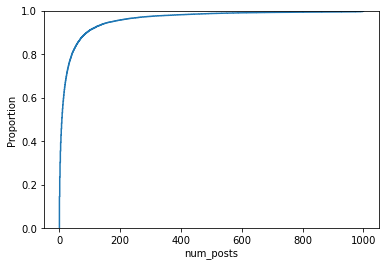

In [65]:
sns.ecdfplot(data = post_counts, x = "num_posts")

<AxesSubplot:xlabel='num_comments', ylabel='Proportion'>

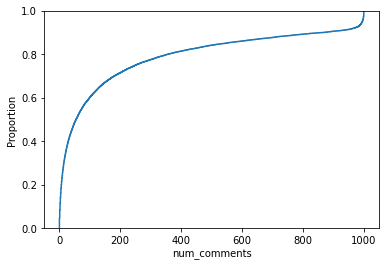

In [67]:
sns.ecdfplot(data = comment_counts, x = "num_comments")

### MH Subs

In [92]:
mh_users = metadata[metadata.subreddit.isin(MH_subs)].username.unique().tolist()
len(mh_users)

26729

In [93]:
first_mh_dates = metadata[(metadata.subreddit.isin(MH_subs))&(metadata.username.isin(mh_users))].\
                         groupby('username').\
                         date.\
                         agg(first_mh_post = np.min, last_mh_post = np.max).\
                         reset_index()
first_mh_dates.head()

,username,first_mh_post,last_mh_post
0,---AmoEboid---,2016-02-09 21:54:10,2021-04-01 14:08:29
1,---Py,2021-03-15 13:50:57,2021-03-15 13:50:57
2,---Thrownaway---,2021-03-28 14:53:28,2021-03-29 13:03:42
3,---no,2019-06-17 16:50:44,2021-03-30 13:24:51
4,--2K--,2021-03-30 17:05:20,2021-03-30 17:11:39


### Combined Analysis

In [94]:
account_info = pd.merge(post_counts, account_dates, on = 'username')
account_info = pd.merge(comment_counts, account_info, on ='username')
account_info = pd.merge(account_info, first_mh_dates, on ='username' )

Text(0, 0.5, 'Number of Users Left')

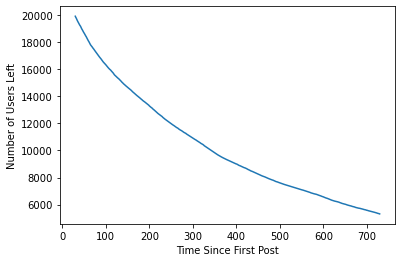

In [97]:
num_users = []
MAX_RANGE = 365*2

for i in range(30,MAX_RANGE):
    try:
        num_users.append(account_info[account_info['account_age']>i].shape[0])
    except:
        break
    
fig = plt.figure()
ax = plt.axes()

ax.plot(list(range(30,MAX_RANGE)), num_users);
plt.xlabel('Time Since First Post')
plt.ylabel('Number of Users Left')

In [103]:
users_to_keep = account_info[account_info['account_age'] > 730].username.unique().tolist() # account age is more than 2 years

In [106]:
control_meta = metadata[metadata.username.isin(users_to_keep)]
control_meta.shape

(2986968, 8)

In [107]:
control_meta = control_meta.to_csv('target_0.csv', index = False)